In [1]:
# Import dependencies
import pandas as pd
import matplotlib.pyplot as plt
import uuid

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler # OneHotEncoder
# from sklearn.pipeline import Pipeline
# from sklearn.impute import SimpleImputer
# from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier  # Example model

import tensorflow as tf

2024-03-23 10:16:57.253746: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-23 10:16:57.805765: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# read csv
df = pd.read_csv('./resources/mxmh_survey_results.csv')
df.head()

,Timestamp,Age,Primary streaming service,Hours per day,While working,Instrumentalist,Composer,Fav genre,Exploratory,Foreign languages,...,Frequency [R&B],Frequency [Rap],Frequency [Rock],Frequency [Video game music],Anxiety,Depression,Insomnia,OCD,Music effects,Permissions
0,8/27/2022 19:29:02,18.0,Spotify,3.0,Yes,Yes,Yes,Latin,Yes,Yes,...,Sometimes,Very frequently,Never,Sometimes,3.0,0.0,1.0,0.0,NaN,I understand.
1,8/27/2022 19:57:31,63.0,Pandora,1.5,Yes,No,No,Rock,Yes,No,...,Sometimes,Rarely,Very frequently,Rarely,7.0,2.0,2.0,1.0,NaN,I understand.
2,8/27/2022 21:28:18,18.0,Spotify,4.0,No,No,No,Video game music,No,Yes,...,Never,Rarely,Rarely,Very frequently,7.0,7.0,10.0,2.0,No effect,I understand.
3,8/27/2022 21:40:40,61.0,YouTube Music,2.5,Yes,No,Yes,Jazz,Yes,Yes,...,Sometimes,Never,Never,Never,9.0,7.0,3.0,3.0,Improve,I understand.
4,8/27/2022 21:54:47,18.0,Spotify,4.0,Yes,No,No,R&B,Yes,No,...,Very frequently,Very frequently,Never,Rarely,7.0,2.0,5.0,9.0,Improve,I understand.


## Data Cleaning

### Renaming

In [3]:
# function to reformat columns lowercase w/o spaces/braces
def col_mapper(old):
    lower = old.lower()
    underscore = lower.replace(' ', '_')
    new = underscore.replace('[', '').replace(']', '') # 1 level of abstraction
    return new

In [4]:
df.rename(columns=col_mapper, inplace=True)
print(df.columns)

Index(['timestamp', 'age', 'primary_streaming_service', 'hours_per_day',
       'while_working', 'instrumentalist', 'composer', 'fav_genre',
       'exploratory', 'foreign_languages', 'bpm', 'frequency_classical',
       'frequency_country', 'frequency_edm', 'frequency_folk',
       'frequency_gospel', 'frequency_hip_hop', 'frequency_jazz',
       'frequency_k_pop', 'frequency_latin', 'frequency_lofi',
       'frequency_metal', 'frequency_pop', 'frequency_r&b', 'frequency_rap',
       'frequency_rock', 'frequency_video_game_music', 'anxiety', 'depression',
       'insomnia', 'ocd', 'music_effects', 'permissions'],
      dtype='object')


## Data discovery

In [5]:
print(len(df))

736


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 736 entries, 0 to 735
Data columns (total 33 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   timestamp                   736 non-null    object 
 1   age                         735 non-null    float64
 2   primary_streaming_service   735 non-null    object 
 3   hours_per_day               736 non-null    float64
 4   while_working               733 non-null    object 
 5   instrumentalist             732 non-null    object 
 6   composer                    735 non-null    object 
 7   fav_genre                   736 non-null    object 
 8   exploratory                 736 non-null    object 
 9   foreign_languages           732 non-null    object 
 10  bpm                         629 non-null    float64
 11  frequency_classical         736 non-null    object 
 12  frequency_country           736 non-null    object 
 13  frequency_edm               736 non

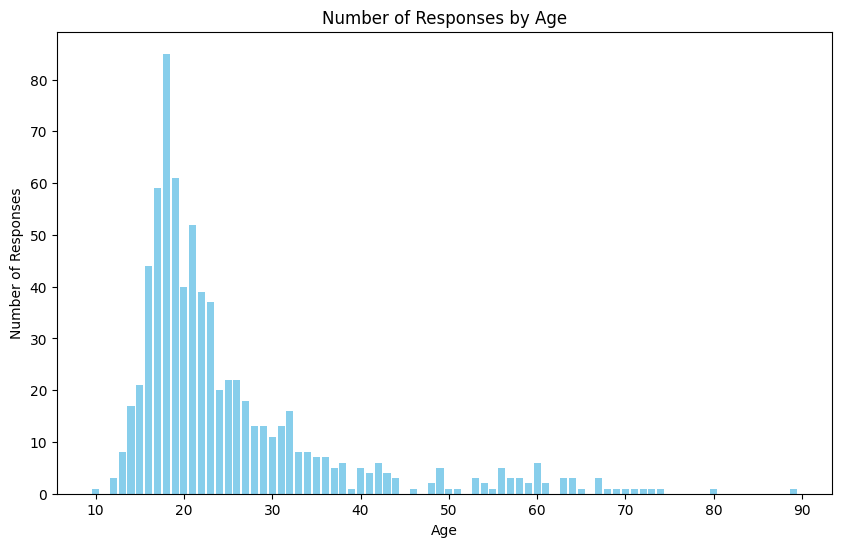

In [7]:
# responses by age
age_counts = df['age'].value_counts()
age_counts

plt.figure(figsize=(10, 6))
plt.bar(age_counts.index, age_counts.values, color='skyblue')
plt.xlabel('Age')
plt.ylabel('Number of Responses')
plt.title('Number of Responses by Age')
plt.xticks(rotation=0)
plt.show()

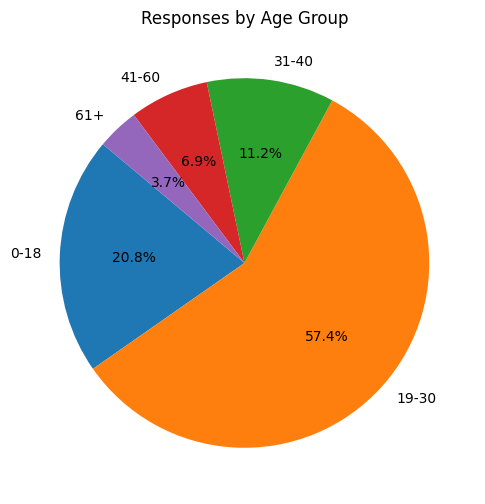

In [8]:
bins =   [0, 18, 30, 40, 60, 90]
labels = ['0-18', '19-30', '31-40', '41-60', '61+']
df['age_group'] = pd.cut(df['age'], bins=bins, labels=labels, right=False)

# Step 3: Aggregation
age_group_counts = df['age_group'].value_counts().sort_index()

# Step 4: Plotting
plt.figure(figsize=(10, 6))  # Adjust the size as needed
plt.pie(age_group_counts, labels=age_group_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Responses by Age Group')
plt.show()

## II. Preprocessing

In [9]:
# add unique id column
df['unique_id'] = [uuid.uuid4() for _ in range(len(df))]
df = df.set_index('unique_id')
df.head(2)

,timestamp,age,primary_streaming_service,hours_per_day,while_working,instrumentalist,composer,fav_genre,exploratory,foreign_languages,...,frequency_rap,frequency_rock,frequency_video_game_music,anxiety,depression,insomnia,ocd,music_effects,permissions,age_group
unique_id,,,,,,,,,,,,,,,,,,,,,
f0d34262-032f-4af4-a83d-f96d83926d94,8/27/2022 19:29:02,18.0,Spotify,3.0,Yes,Yes,Yes,Latin,Yes,Yes,...,Very frequently,Never,Sometimes,3.0,0.0,1.0,0.0,NaN,I understand.,19-30
8cbdf239-e613-4340-b74e-e5d48c5dbc36,8/27/2022 19:57:31,63.0,Pandora,1.5,Yes,No,No,Rock,Yes,No,...,Rarely,Very frequently,Rarely,7.0,2.0,2.0,1.0,NaN,I understand.,61+


In [10]:
# replace improve with 1
df = df.replace({
    'Improve': 1,
    'No effect': 0,
    'Worsen': 0
})
df['music_effects'][0:5]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 736 entries, f0d34262-032f-4af4-a83d-f96d83926d94 to e97e1473-54e7-4dbf-8061-4ad278de1b39
Data columns (total 34 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   timestamp                   736 non-null    object  
 1   age                         735 non-null    float64 
 2   primary_streaming_service   735 non-null    object  
 3   hours_per_day               736 non-null    float64 
 4   while_working               733 non-null    object  
 5   instrumentalist             732 non-null    object  
 6   composer                    735 non-null    object  
 7   fav_genre                   736 non-null    object  
 8   exploratory                 736 non-null    object  
 9   foreign_languages           732 non-null    object  
 10  bpm                         629 non-null    float64 
 11  frequency_classical         736 non-null    object  
 12  frequency_count

/tmp/ipykernel_53261/3433361303.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace({


In [11]:
# drop unhelpful columns
cols_to_drop = [
    'bpm', # too few responses and too many 
    'permissions', # everyone answered yes
    'age_group',
    'timestamp'
    ]

# NEW DF - cleaned
cleaned_df = df.drop(columns=cols_to_drop)
print(cleaned_df.columns)
print(f'Num of columns: {len(cleaned_df.columns)}')

Index(['age', 'primary_streaming_service', 'hours_per_day', 'while_working',
       'instrumentalist', 'composer', 'fav_genre', 'exploratory',
       'foreign_languages', 'frequency_classical', 'frequency_country',
       'frequency_edm', 'frequency_folk', 'frequency_gospel',
       'frequency_hip_hop', 'frequency_jazz', 'frequency_k_pop',
       'frequency_latin', 'frequency_lofi', 'frequency_metal', 'frequency_pop',
       'frequency_r&b', 'frequency_rap', 'frequency_rock',
       'frequency_video_game_music', 'anxiety', 'depression', 'insomnia',
       'ocd', 'music_effects'],
      dtype='object')
Num of columns: 30


In [12]:
# drop remaining rows with null values
cleaned_df = cleaned_df.dropna()
cleaned_df.isnull().sum()

age                           0
primary_streaming_service     0
hours_per_day                 0
while_working                 0
instrumentalist               0
composer                      0
fav_genre                     0
exploratory                   0
foreign_languages             0
frequency_classical           0
frequency_country             0
frequency_edm                 0
frequency_folk                0
frequency_gospel              0
frequency_hip_hop             0
frequency_jazz                0
frequency_k_pop               0
frequency_latin               0
frequency_lofi                0
frequency_metal               0
frequency_pop                 0
frequency_r&b                 0
frequency_rap                 0
frequency_rock                0
frequency_video_game_music    0
anxiety                       0
depression                    0
insomnia                      0
ocd                           0
music_effects                 0
dtype: int64

In [13]:
# log number of rows dropped and remaining
print(f'{len(df)-len(cleaned_df)} rows dropped ({len(cleaned_df)} remaining)')

18 rows dropped (718 remaining)


### Encoding results in `df_encoded`

In [14]:
df_encoded = cleaned_df.copy()
df_encoded.info() # is there a way get the number of null values in all columns so I can print it out?

<class 'pandas.core.frame.DataFrame'>
Index: 718 entries, be9740c1-163c-41fa-b05a-809552af71ed to e97e1473-54e7-4dbf-8061-4ad278de1b39
Data columns (total 30 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   age                         718 non-null    float64
 1   primary_streaming_service   718 non-null    object 
 2   hours_per_day               718 non-null    float64
 3   while_working               718 non-null    object 
 4   instrumentalist             718 non-null    object 
 5   composer                    718 non-null    object 
 6   fav_genre                   718 non-null    object 
 7   exploratory                 718 non-null    object 
 8   foreign_languages           718 non-null    object 
 9   frequency_classical         718 non-null    object 
 10  frequency_country           718 non-null    object 
 11  frequency_edm               718 non-null    object 
 12  frequency_folk              7

In [15]:
# making yes/no columns binary
columns_for_conversion = ['instrumentalist', 'composer', 'while_working']

for col in columns_for_conversion:
    df_encoded[col] = df_encoded[col].map({
        'Yes': 1,
        'No' : 0
        })

df_encoded.head()

,age,primary_streaming_service,hours_per_day,while_working,instrumentalist,composer,fav_genre,exploratory,foreign_languages,frequency_classical,...,frequency_pop,frequency_r&b,frequency_rap,frequency_rock,frequency_video_game_music,anxiety,depression,insomnia,ocd,music_effects
unique_id,,,,,,,,,,,,,,,,,,,,,
be9740c1-163c-41fa-b05a-809552af71ed,18.0,Spotify,4.0,0,0,0,Video game music,No,Yes,Never,...,Rarely,Never,Rarely,Rarely,Very frequently,7.0,7.0,10.0,2.0,0.0
d2daca1f-5b4f-4062-b9fc-df188f4e5287,61.0,YouTube Music,2.5,1,0,1,Jazz,Yes,Yes,Sometimes,...,Sometimes,Sometimes,Never,Never,Never,9.0,7.0,3.0,3.0,1.0
e003e3d2-596f-4ad1-9c5a-5ea05de75000,18.0,Spotify,4.0,1,0,0,R&B,Yes,No,Never,...,Sometimes,Very frequently,Very frequently,Never,Rarely,7.0,2.0,5.0,9.0,1.0
5d5f9139-bb3f-4be9-a924-e9a80a6d8130,18.0,Spotify,5.0,1,1,1,Jazz,Yes,Yes,Rarely,...,Very frequently,Very frequently,Very frequently,Very frequently,Never,8.0,8.0,7.0,7.0,1.0
f7acbf32-7e13-446a-9d5c-3cb1d76ee81c,18.0,YouTube Music,3.0,1,1,0,Video game music,Yes,Yes,Sometimes,...,Rarely,Rarely,Never,Never,Sometimes,4.0,8.0,6.0,0.0,1.0


In [16]:
# change frequency_<genre> values to 0-3
frequency_mapping = {
    'Never': 0,
    'Rarely': 1,
    'Sometimes': 2,
    'Very frequently': 3
}

# loop to change all frequency_<genre> columns
for col in df_encoded.columns:
    if col.startswith('frequency_'):
        df_encoded[col] = df_encoded[col].map(frequency_mapping)

df_encoded.head()

,age,primary_streaming_service,hours_per_day,while_working,instrumentalist,composer,fav_genre,exploratory,foreign_languages,frequency_classical,...,frequency_pop,frequency_r&b,frequency_rap,frequency_rock,frequency_video_game_music,anxiety,depression,insomnia,ocd,music_effects
unique_id,,,,,,,,,,,,,,,,,,,,,
be9740c1-163c-41fa-b05a-809552af71ed,18.0,Spotify,4.0,0,0,0,Video game music,No,Yes,0,...,1,0,1,1,3,7.0,7.0,10.0,2.0,0.0
d2daca1f-5b4f-4062-b9fc-df188f4e5287,61.0,YouTube Music,2.5,1,0,1,Jazz,Yes,Yes,2,...,2,2,0,0,0,9.0,7.0,3.0,3.0,1.0
e003e3d2-596f-4ad1-9c5a-5ea05de75000,18.0,Spotify,4.0,1,0,0,R&B,Yes,No,0,...,2,3,3,0,1,7.0,2.0,5.0,9.0,1.0
5d5f9139-bb3f-4be9-a924-e9a80a6d8130,18.0,Spotify,5.0,1,1,1,Jazz,Yes,Yes,1,...,3,3,3,3,0,8.0,8.0,7.0,7.0,1.0
f7acbf32-7e13-446a-9d5c-3cb1d76ee81c,18.0,YouTube Music,3.0,1,1,0,Video game music,Yes,Yes,2,...,1,1,0,0,2,4.0,8.0,6.0,0.0,1.0


In [17]:
df_encoded['music_effects'].value_counts()

music_effects
1.0    535
0.0    183
Name: count, dtype: int64

In [18]:
df_encoded = pd.get_dummies(df_encoded, columns=[
    'primary_streaming_service',
    'while_working',
    'fav_genre',
    'exploratory',
    'foreign_languages',
    # 'music_effects'
    ],
    dtype=int
) # automatically without columns converts non numeric values

pd.set_option('display.max_columns', None)
df_encoded.head()

,age,hours_per_day,instrumentalist,composer,frequency_classical,frequency_country,frequency_edm,frequency_folk,frequency_gospel,frequency_hip_hop,frequency_jazz,frequency_k_pop,frequency_latin,frequency_lofi,frequency_metal,frequency_pop,frequency_r&b,frequency_rap,frequency_rock,frequency_video_game_music,anxiety,depression,insomnia,ocd,music_effects,primary_streaming_service_Apple Music,primary_streaming_service_I do not use a streaming service.,primary_streaming_service_Other streaming service,primary_streaming_service_Pandora,primary_streaming_service_Spotify,primary_streaming_service_YouTube Music,while_working_0,while_working_1,fav_genre_Classical,fav_genre_Country,fav_genre_EDM,fav_genre_Folk,fav_genre_Gospel,fav_genre_Hip hop,fav_genre_Jazz,fav_genre_K pop,fav_genre_Latin,fav_genre_Lofi,fav_genre_Metal,fav_genre_Pop,fav_genre_R&B,fav_genre_Rap,fav_genre_Rock,fav_genre_Video game music,exploratory_No,exploratory_Yes,foreign_languages_No,foreign_languages_Yes
unique_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
be9740c1-163c-41fa-b05a-809552af71ed,18.0,4.0,0,0,0,0,3,0,0,1,1,3,0,2,2,1,0,1,1,3,7.0,7.0,10.0,2.0,0.0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1
d2daca1f-5b4f-4062-b9fc-df188f4e5287,61.0,2.5,0,1,2,0,0,1,2,0,3,2,3,2,0,2,2,0,0,0,9.0,7.0,3.0,3.0,1.0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1
e003e3d2-596f-4ad1-9c5a-5ea05de75000,18.0,4.0,0,0,0,0,1,0,1,3,0,3,2,2,0,2,3,3,0,1,7.0,2.0,5.0,9.0,1.0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0
5d5f9139-bb3f-4be9-a924-e9a80a6d8130,18.0,5.0,1,1,1,2,0,0,0,2,3,3,1,3,1,3,3,3,3,0,8.0,8.0,7.0,7.0,1.0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1
f7acbf32-7e13-446a-9d5c-3cb1d76ee81c,18.0,3.0,1,0,2,0,1,2,1,1,2,0,1,1,1,1,1,0,0,2,4.0,8.0,6.0,0.0,1.0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1


In [19]:
# df_encoded.drop(columns=['music_effects_No effect', 'music_effects_Worsen'], inplace=True) # ! in place importance
df_encoded['music_effects'].value_counts()

music_effects
1.0    535
0.0    183
Name: count, dtype: int64

In [20]:
# reformat columns to match standard
df_encoded.rename(columns=col_mapper, inplace=True)
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 718 entries, be9740c1-163c-41fa-b05a-809552af71ed to e97e1473-54e7-4dbf-8061-4ad278de1b39
Data columns (total 53 columns):
 #   Column                                                       Non-Null Count  Dtype  
---  ------                                                       --------------  -----  
 0   age                                                          718 non-null    float64
 1   hours_per_day                                                718 non-null    float64
 2   instrumentalist                                              718 non-null    int64  
 3   composer                                                     718 non-null    int64  
 4   frequency_classical                                          718 non-null    int64  
 5   frequency_country                                            718 non-null    int64  
 6   frequency_edm                                                718 non-null    int64  
 7   frequency_folk   

In [21]:
# define target and feature data
target_col = 'music_effects'

y = df_encoded[target_col].values
X = df_encoded.drop(columns=target_col).values

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=17)

print(f"Training features shape: {X_train.shape}")
print(f"Training targets shape: {y_train.shape}")
print(f"Testing features shape: {X_test.shape}")
print(f"Testing targets shape: {y_test.shape}")


Training features shape: (574, 52)
Training targets shape: (574,)
Testing features shape: (144, 52)
Testing targets shape: (144,)


## Model setup and training

### Random Forest

In [23]:
# Initialize the Random Forest Classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model

RandomForestClassifier(random_state=42)

In [25]:
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [26]:
y_pred = model.predict(X_test)

In [27]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, classification_report, confusion_matrix

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Calculate accuracy
bal_accuracy = balanced_accuracy_score(y_test, y_pred)
print(f"Balanced accuracy: {bal_accuracy}")

# Generate a classification report
print(classification_report(y_test, y_pred))

# Generate and display a confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

Accuracy: 0.7916666666666666
Balanced accuracy: 0.53125
              precision    recall  f1-score   support

         0.0       1.00      0.06      0.12        32
         1.0       0.79      1.00      0.88       112

    accuracy                           0.79       144
   macro avg       0.89      0.53      0.50       144
weighted avg       0.84      0.79      0.71       144

[[  2  30]
 [  0 112]]


### Tensorflow

In [28]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [29]:
print(len(X_train[0]))
X_train[0]

52


array([19.,  5.,  1.,  0.,  2.,  1.,  0.,  0.,  0.,  1.,  2.,  0.,  0.,
        0.,  3.,  2.,  2.,  1.,  3.,  0.,  2.,  2.,  0.,  6.,  0.,  0.,
        0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  1.,  0.])

In [40]:
# Define the model - deep neural net
number_input_features = len(X_train[0])
hidden_nodes_layer1 =  100
hidden_nodes_layer2 = 20

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(
    tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu")
)

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="relu"))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
nn.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                 │ (None, 100)            │         5,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 20)             │         2,020 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,341 (28.68 KB)

 Trainable params: 7,341 (28.68 KB)

 Non-trainable params: 0 (0.00 B)

In [41]:
 # Compile the model
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [42]:
# Train the model
fit_model = nn.fit(X_train_scaled,y_train,epochs=100)

Epoch 1/100


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 591us/step - accuracy: 0.7643 - loss: 0.5581
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 513us/step - accuracy: 0.7435 - loss: 0.5418
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 606us/step - accuracy: 0.7478 - loss: 0.5164
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 518us/step - accuracy: 0.7689 - loss: 0.4698
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 514us/step - accuracy: 0.7722 - loss: 0.4619
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step - accuracy: 0.8009 - loss: 0.4312
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 475us/step - accuracy: 0.8104 - loss: 0.4259
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 436us/step - accuracy: 0.8025 - loss: 0.4145
Epoch 9/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step - accuracy: 0.8386 - loss: 0.3857
Epoch 10/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 447us/step - accuracy: 0.8400 - loss: 0.3766
Epoch 11/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 468us/step - accuracy: 0.8438 - loss: 0.3518
Epoch 12/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 488us/step

In [43]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

5/5 - 0s - 38ms/step - accuracy: 0.6875 - loss: 1.7629
Loss: 1.762944221496582, Accuracy: 0.6875
